In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import git
import os

# Get git repository root
repo = git.Repo(".", search_parent_directories = True)
# Update notebook working dir to repository root
os.chdir(repo.working_tree_dir)

# Load frequently used methods
with open("notebooks/methods.py", "r") as file:
    exec(file.read())

with open("python/plot_all_events.py", "r") as file:
    exec(file.read())

# Detection of action potentials

In [2]:
samples = pd.read_csv("sample_sheet.csv")
sample = samples.iloc[1]
sample

SID              W1_C2
AnimalID            W1
CellName            C2
Region          S1_L23
Date        2019 12 09
Depth       265.898093
Count              270
Location         W1/C2
Cortex              S1
Layer              L23
Name: 1, dtype: object

In [3]:
data = pd.read_pickle(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/vm/filter.pkl")
channels = data.ch_names

In [4]:
signal = data.get_data()[6, :]
time = data.times

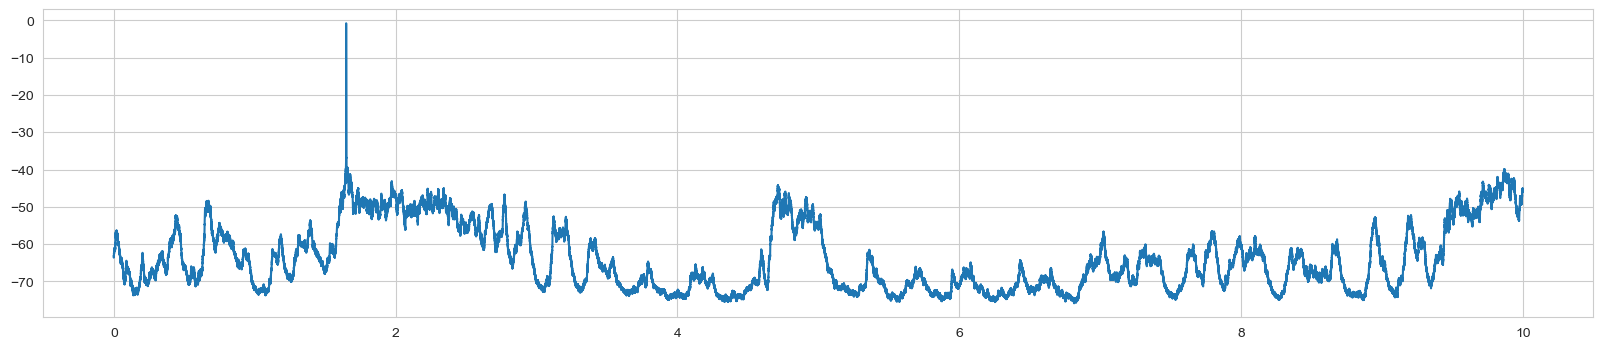

In [5]:
plt.figure(figsize = (20, 4))
plt.plot(time, signal)
plt.show()

In [6]:
differential = np.diff(signal)

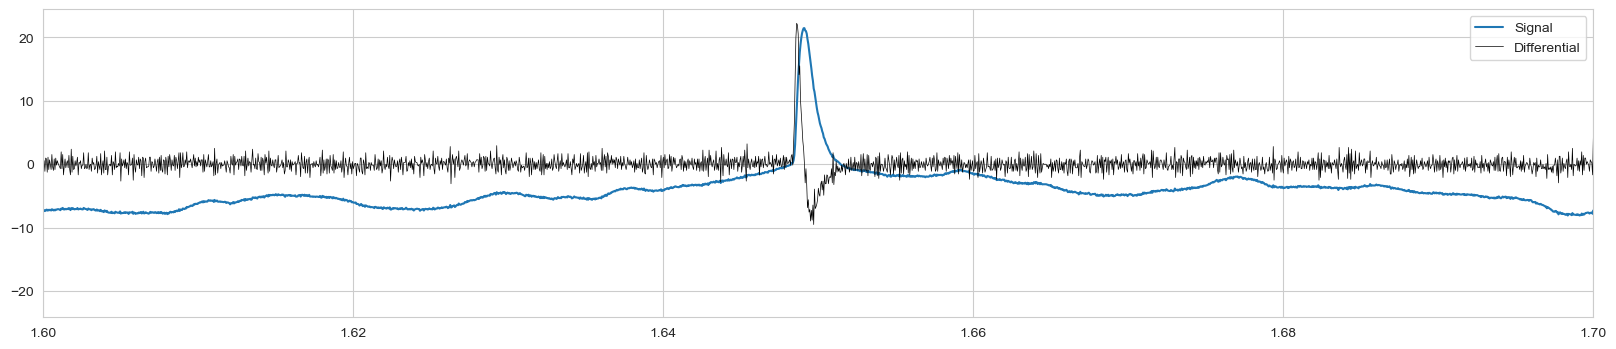

In [7]:
plt.figure(figsize = (20, 4))
plt.plot(time, ((signal - np.mean(signal)) / np.std(signal) - 3) * 5, label = "Signal")
plt.plot(time[1:], (differential - np.mean(differential)) / np.std(differential), linewidth = 0.5, c = "black", label = "Differential")
plt.xlim(1.6, 1.7)
plt.legend()
plt.show()

In [8]:
def find_onset(differential, start_index):
    value = differential[start_index]
    index = start_index

    while value > 1:
        index -= 1
        value = differential[index]

    return index

In [9]:
def find_offset(differential, start_index):
    value = differential[start_index]
    index = start_index

    while value > 0:
        index += 1
        value = differential[index]

    while value < 0:
        index += 1
        value = differential[index]

    return index

In [10]:
def find_ap(differential, time, threshold = 1.5):
    over_threshold = np.where(differential > threshold)[0]

    if len(over_threshold) == 0:
        return []

    idx_diff = np.where(np.diff(over_threshold) != 1)[0]
    detected = np.append(over_threshold[0], over_threshold[idx_diff + 1])

    aps = []
    for ap in detected:
        onset = find_onset(differential, start_index = ap)
        offset = find_offset(differential, start_index = ap)
    
        aps.append(pd.DataFrame({
            "StartIndex": [onset],
            "EndIndex": [offset],
            "Start": [time[onset]],
            "End": [time[onset]]
        }))
    
    aps = pd.concat(aps)

    return aps

In [11]:
aps = find_ap(differential, time, threshold = 1.5)
ap = aps.iloc[0]

start = round(ap["StartIndex"])
end = round(ap["EndIndex"])
startTime = round(ap["Start"], 2) - 0.05
endTime = round(ap["End"], 2) + 0.05

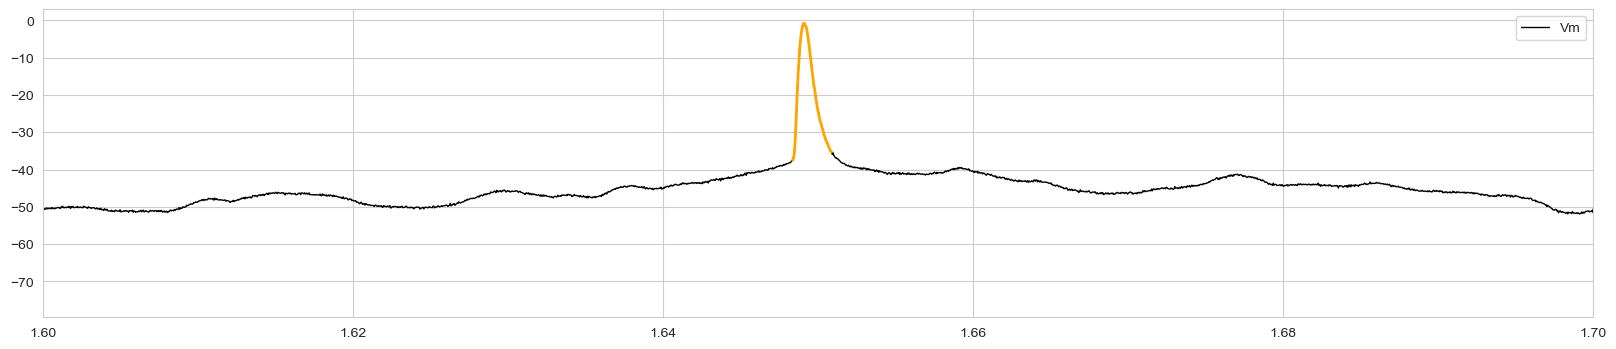

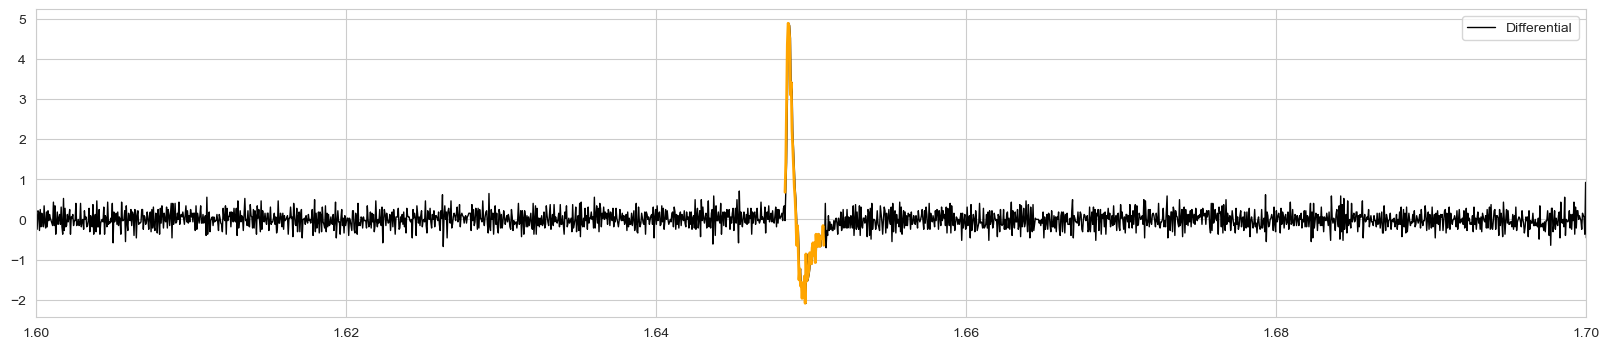

In [12]:
plt.figure(figsize = (20, 4))
plt.plot(time[:], signal, linewidth = 1, color = "black", label = "Vm")

plt.plot(time[start:end], signal[start:end], linewidth = 2, color = "orange")

plt.xlim(startTime, endTime)
plt.legend()
plt.show()


plt.figure(figsize = (20, 4))
plt.plot(time[1:], differential, linewidth = 1, c = "black", label = "Differential")

plt.plot(time[start:end], differential[start:end], linewidth = 2, color = "orange")

plt.xlim(startTime, endTime)
plt.legend()
plt.show()